## Task 3 : Prompt Engineering for Large Language Models (LLMs) [4 marks]
### Importing Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import os
from dotenv import load_dotenv
import random
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from langchain_groq.chat_models import ChatGroq
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Loading Files

In [12]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
#                                   ES335- Machine Learning- Assignment 1
#
# This file is used to create the dataset for the mini-project. The dataset is created by reading the data from
# the Combined folder. The data is then split into training, testing, and validation sets. This split is supposed
# to be used for all the modeling purposes.
#
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# Constants
time = 10
offset = 100
folders = ["LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]
classes = {"WALKING": 1, "WALKING_UPSTAIRS": 2, "WALKING_DOWNSTAIRS": 3, "SITTING": 4, "STANDING": 5, "LAYING": 6}

combined_dir = os.path.join("Combined")

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Train Dataset
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

X_train = []
y_train = []
dataset_dir = os.path.join(combined_dir, "Train")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir, folder))

    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir, folder, file), sep=",", header=0)
        df = df[offset:offset + time * 50]
        X_train.append(df.values)
        y_train.append(classes[folder])

X_train = np.array(X_train)
y_train = np.array(y_train)

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Test Dataset
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

X_test = []
y_test = []
dataset_dir = os.path.join(combined_dir, "Test")

for folder in folders:
    files = os.listdir(os.path.join(dataset_dir, folder))
    for file in files:
        df = pd.read_csv(os.path.join(dataset_dir, folder, file), sep=",", header=0)
        df = df[offset:offset + time * 50]
        X_test.append(df.values)
        y_test.append(classes[folder])

X_test = np.array(X_test)
y_test = np.array(y_test)

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Final Dataset
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# USE THE BELOW GIVEN DATA FOR TRAINING and TESTING purposes

# concatenate the training and testing data
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

# split the data into training and testing sets. Change the seed value to obtain different random splits.
seed = 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


### Creating DataFrames

We extract the `spectral` data features using tsfel from the raw accelerometer data provided.  
Then, we `standardize` the features and perform PCA on the data, extractind the top `5 Principal components`

In [14]:
# Applying PCA on features obtained by TSFEL featurizer library.
import tsfel

train_df = pd.DataFrame(np.concatenate((X_train.reshape((-1, 3)), np.repeat(y_train, 500).reshape(-1,1)), axis = 1), columns = ["accx", "accy", "accz", "Label"])
train_df["totalacc"] = train_df["accx"]**2 + train_df["accy"]**2 + train_df["accz"]**2

test_df = pd.DataFrame(np.concatenate((X_test.reshape((-1, 3)), np.repeat(y_test, 500).reshape(-1,1)), axis = 1), columns = ["accx", "accy", "accz", "Label"])
test_df["totalacc"] = test_df["accx"]**2 + test_df["accy"]**2 + test_df["accz"]**2

cfg = tsfel.get_features_by_domain('spectral')
scaler = StandardScaler()

features_train = scaler.fit_transform(tsfel.time_series_features_extractor(cfg, train_df[["accx","accy","accz"]], fs=50, window_size=500))
features_test = scaler.fit_transform(tsfel.time_series_features_extractor(cfg, test_df[["accx","accy","accz"]], fs=50, window_size=500))

pca = PCA(n_components = 5)
pca_features_train = pca.fit_transform(features_train)
pca_features_test = pca.fit_transform(features_test)
print("Final training dataset after tsfel spectral feature extraction and PCA down to 5 principal components:", pca_features_train.shape)
print("Final testing dataset after tsfel spectral feature extraction and PCA down to 5 principal components:", pca_features_test.shape)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Final training dataset after tsfel spectral feature extraction and PCA down to 5 principal components: (126, 5)
Final testing dataset after tsfel spectral feature extraction and PCA down to 5 principal components: (54, 5)


In [108]:
# Label wise distribution of the data
train_df_class_1 = pd.DataFrame(pca_features_train[:21, :])
train_df_class_2 = pd.DataFrame(pca_features_train[21:42, :])
train_df_class_3 = pd.DataFrame(pca_features_train[42:63, :])
train_df_class_4 = pd.DataFrame(pca_features_train[63:84, :])
train_df_class_5 = pd.DataFrame(pca_features_train[84:105, :])
train_df_class_6 = pd.DataFrame(pca_features_train[105:, :])

test_df_class_1 = pd.DataFrame(pca_features_test[:9, :])
test_df_class_2 = pd.DataFrame(pca_features_test[9:18, :])
test_df_class_3 = pd.DataFrame(pca_features_test[18:27, :])
test_df_class_4 = pd.DataFrame(pca_features_test[27:36, :])
test_df_class_5 = pd.DataFrame(pca_features_test[36:45, :])
test_df_class_6 = pd.DataFrame(pca_features_test[45:, :])

print("Shape of dataframe of 1 training activity set:", train_df_class_1.shape)
print("Shape of dataframe of 1 testing activity set:", test_df_class_1.shape)

Shape of dataframe of 1 training activity set: (21, 5)
Shape of dataframe of 1 testing activity set: (9, 5)


### Loading Model and API key

> The `API Keys` are stored in a secret `.env` file which is not tracked by git.

In [140]:
# Groq API and Models 
load_dotenv()
groq_api_key_akash = os.getenv("API_KEY_AKASH") #loading api keys from .env file 
groq_api_key_romit= os.getenv("API_KEY_ROMIT")

groq_models = {
    "llama3-70b": "llama3-70b-8192", 
    "mixtral": "mixtral-8x7b-32768", 
    "gemma-7b": "gemma-7b-it",
    "llama3.1-70b":"llama-3.1-70b-versatile",
    "llama3-8b":"llama3-8b-8192",
    "llama3.1-8b":"llama-3.1-8b-instant",
    "gemma-9b":"gemma2-9b-it"
}

modelName = "llama3.1-70b"

llm = ChatGroq(model=groq_models[modelName], api_key=groq_api_key_romit, temperature=0)

### 1. Demonstrate how to use Zero-Shot Learning and Few-Shot Learning to classify human activities based on the featurized accelerometer data. Qualitatively demonstrate the performance of Few-Shot Learning with Zero-Shot Learning. Which method performs better? Why? [1 marks]

For both `Zero Shot Learning` and `Few Shot Learning`, we'll be using the `test_df`s created after applying PCA to the data obtained after extracting the `spectral` features using tsfel from the original `UCI-HAR` dataset to get classification answers and tell accuracy.

- Zero Shot Learning

In [56]:
# code for zero shot with raw x, y, and z data

# total_window_width = 5 # in seconds
# ind_window_width = 0.2 # in seconds
# sampling_rate = 50 #in Hertz
# num_of_windows = total_window_width / ind_window_width

# # function to get test data timeseries from testing dataset
# def get_avg_acc_data(start_seconds, activity_class):
#     match activity_class:
#         case 1:
#             df = test_df_class_1
#         case 2:
#             df = test_df_class_2
#         case 3:
#             df = test_df_class_3
#         case 4:
#             df = test_df_class_4
#         case 5:
#             df = test_df_class_5
#         case 6:
#             df = test_df_class_6
#     # Get the average data from the dataframe
#     # print(df.head())
#     five_sec_data = df[["accx", "accy", "accz"]][start_seconds * sampling_rate:(start_seconds + 5) * sampling_rate]
#     avg_data = [np.mean(window, axis=0).to_list() for window in np.array_split(five_sec_data, num_of_windows)]

#     #plotting the generated data
#     # plt.plot(np.arange(start_seconds, start_seconds + total_window_width, ind_window_width), [data[0] for data in avg_data], label="x")
#     # plt.plot(np.arange(start_seconds, start_seconds + total_window_width, ind_window_width), [data[1] for data in avg_data], label="y")
#     # plt.plot(np.arange(start_seconds, start_seconds + total_window_width, ind_window_width), [data[2] for data in avg_data], label="z")
#     # plt.legend()
#     # plt.ylim(-1, 2)
#     # plt.show()

#     return avg_data

# function to get data vector from a specified activity class
# get_avg_acc_data(0, 1) # example usage
def get_random_data(activity_class, r):
    match activity_class:
        case 1:
            df = test_df_class_1
        case 2:
            df = test_df_class_2
        case 3:
            df = test_df_class_3
        case 4:
            df = test_df_class_4
        case 5:
            df = test_df_class_5
        case 6:
            df = test_df_class_6
    
    return df.iloc[r]


def build_query_zeroshot(string):
    return f"""
    * You are a Human Activity Recognition model. 
    * Your task is to classify the given data as one of the six activity classes listed below.
    * The data is recorded by accelerometer positioned above the torso of the person.
    * The data's format is as such that each line contains the top 5 principal components of the tsfel spectral data extracted by 10 seconds of the activity's accelerometer data.
    
    1. Walking
    2. Walking Upstairs
    3. Walking Downstairs
    4. Sitting
    5. Standing
    6. Lying Down

    * Provide JUST the number corresponding to the predicted activity

    data: 
    {string}
    """ 

In [75]:
m_iters = 5
iters = 10

def evaluate_llm_zeroshot(iters = 10):
    runs_results = []
    runs_results_staticdynamic = []
    for _ in range(iters):
        crct_class = random.randint(1, 6)
        sample = random.randint(0, 8) # 9 is length of a testing dataframe of a specific activity
        data = get_random_data(crct_class, sample)
        data_string = "\n".join([str(point) for point in data])
        query = build_query_zeroshot(data_string)
        
        answer = llm.invoke(query)

        # print(answer.content, crct_class)
        pred_digit = int(answer.content.split()[-1].lstrip("(").rstrip(")."))
        runs_results.append(1 if pred_digit == crct_class else 0)
        runs_results_staticdynamic.append(1 if (pred_digit in [1, 2, 3] and crct_class in [1, 2, 3]) or (pred_digit in [4, 5, 6] and crct_class in [4, 5, 6]) else 0)
    
    return (np.round(np.mean(runs_results), 4), np.round(np.mean(runs_results_staticdynamic), 4))


print(list(classes.items()))
accuracies = []
accuracies_staticdynamic = []
for _ in range(m_iters):
    accuracy = evaluate_llm_zeroshot(iters=iters)
    accuracies.append(accuracy[0])
    accuracies_staticdynamic.append(accuracy[1])

print(f"Max Accuracy over {m_iters} runs of {iters} prompts each:", max(accuracies) * 100, "\nMean:", np.round(np.mean(accuracies) * 100, 2))
print("Max Accuracy for just differentiating between static and dynamic activities:", max(accuracies_staticdynamic) * 100, "\nMean:", np.round(np.mean(accuracies_staticdynamic) * 100, 2))


[('WALKING', 1), ('WALKING_UPSTAIRS', 2), ('WALKING_DOWNSTAIRS', 3), ('SITTING', 4), ('STANDING', 5), ('LAYING', 6)]
Max Accuracy over 5 runs of 10 prompts each: 40.0 
Mean: 24.0
Max Accuracy for just differentiating between static and dynamic activities: 80.0 
Mean: 54.0


**For ZeroShot learning with raw x, y and z accelerometer data**
> Max Accuracy over 5 runs of 20 prompts each: 30.0  
> Mean: 20.0  
> Max Accuracy for just differentiating between static and dynamic activities: 80.0  
> Mean: 69.0

**For ZeroShot Learning with standardized tsfel data after PCA**
> Max Accuracy over 5 runs of 10 prompts each: 40.0   
> Mean: 24.0  
> Max Accuracy for just differentiating between static and dynamic activities: 80.0   
>Mean: 54.0

_This testing was done using the model `llama3-70b`_

- Few Shot Learning

> We provide the example data (from `training dataset`) along with their correct labels for each class of activity to the model first, then we ask it to classify a vector from the `test_df`  
> The LLM receives the same training data for `iters` prompts but different testing data vector, after that the training data also changes.  
> This is repeated for `m_iters` number of times

In [138]:
ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING',
}

# function to get example data timeseries for prompt - from training dataset for few shot learning with raw x, y and z data points
# def get_avg_acc_train_data(start_seconds, activity_class):
#     match activity_class:
#         case 1:
#             df = train_df_class_1
#         case 2:
#             df = train_df_class_2
#         case 3:
#             df = train_df_class_3
#         case 4:
#             df = train_df_class_4
#         case 5:
#             df = train_df_class_5
#         case 6:
#             df = train_df_class_6
#     # Get the average data from the dataframe
#     # print(df.head())
#     five_sec_data = df[["accx", "accy", "accz"]][start_seconds * sampling_rate:(start_seconds + 5) * sampling_rate]
#     avg_data = [np.mean(window, axis=0).to_list() for window in np.array_split(five_sec_data, num_of_windows)]

#     return avg_data

def build_query_fewshot(train, test):
    return f"""
    * You are a Human Activity Recognition model. 
    * Your task is to classify the given data as one of the six activity classes listed below.
    * The data is recorded by accelerometer positioned above the torso of the person.
    * The data's format is as such that each line contains the top 5 principal components after PCA of the standardized tsfel spectral data extracted from 10 seconds of the activity's accelerometer data.
    * Pay attention to the examples given.

    1. Walking
    2. Walking Upstairs
    3. Walking Downstairs
    4. Sitting
    5. Standing
    6. Lying Down

    *Here are few examples:
    {train}

    * Provide JUST the number corresponding to the predicted activity

    data: 
    {test}
    """ 

In [141]:
m_iters = 3
iters = 10
number_of_examples = 6  # change this to 3 and 6 respectively to get 3shot and 6shot data

def evaluate_llm_fewshot(iters = 10):
    runs_results = []
    runs_results_staticdynamic = []
    
    train_string = ""

    for i in range(number_of_examples):
        c = (i % 6) + 1  # class number
        sample = random.randint(0, 8) # 9 is length of a testing dataframe of a specific activity
        train_string += str(i+1) + ". Vector data:\n" + ", ".join([str(point) for point in get_random_data(c, sample)]) + "\nActivity: " + str(c) + ": " + ACTIVITIES[c] + "\n\n"

    for _ in range(iters):
        crct_class = random.randint(1, 6)
        sample = random.randint(0, 8) # 9 is length of a testing dataframe of a specific activity
        test_data = get_random_data(crct_class, sample)
        test_string = "\n".join([str(point) for point in test_data])
        query = build_query_fewshot(train_string, test_string)
        # print(query)
        
        answer = llm.invoke(query)

        # print(answer.content, crct_class)
        pred_digit = int(answer.content.split()[-1].lstrip("(").rstrip(")."))
        runs_results.append(1 if pred_digit == crct_class else 0)
        runs_results_staticdynamic.append(1 if (pred_digit in [1, 2, 3] and crct_class in [1, 2, 3]) or (pred_digit in [4, 5, 6] and crct_class in [4, 5, 6]) else 0)
    
    return (np.round(np.mean(runs_results), 4), np.round(np.mean(runs_results_staticdynamic), 4))


# print(list(classes.items()))
accuracies = []
accuracies_staticdynamic = []
for _ in range(m_iters):
    accuracy = evaluate_llm_fewshot(iters=iters)
    accuracies.append(accuracy[0])
    accuracies_staticdynamic.append(accuracy[1])

In [142]:
print(f"Max Accuracy over {m_iters} runs of {iters} prompts each: ({number_of_examples} shots)", max(accuracies) * 100, "\nMean:", np.round(np.mean(accuracies) * 100, 2))
print("Max Accuracy for just differentiating between static and dynamic activities:", max(accuracies_staticdynamic) * 100, "\nMean:", np.round(np.mean(accuracies_staticdynamic) * 100, 2))

Max Accuracy over 3 runs of 10 prompts each: (6 shots) 50.0 
Mean: 33.33
Max Accuracy for just differentiating between static and dynamic activities: 50.0 
Mean: 46.67


**For ZeroShot learning with `raw x, y and z` accelerometer data**
> Max Accuracy over 3 runs of 20 prompts each: (1 shot) `40`   
> Mean: `25`  
> Max Accuracy for just differentiating between static and dynamic activities: 60.0  
> Mean: 51.11

> Max Accuracy over 3 runs of 20 prompts each: (3 shots) `55.0`  
> Mean: `45.0`  
> Max Accuracy for just differentiating between static and dynamic activities: 100.0  
> Mean: 100.0

> Max Accuracy over 3 runs of 20 prompts each: (6 shots)  `60.0`  
> Mean: `46.67`  
> Max Accuracy for just differentiating between static and dynamic activities: 90.0  
> Mean: 83.33

**For ZeroShot Learning with `standardized tsfel data after PCA`**
> Max Accuracy over 3 runs of 10 prompts each: (1 shot) `46.67`   
> Mean: `33.34`  
> Max Accuracy for just differentiating between static and dynamic activities: 60.0  
> Mean: 51.11

> Max Accuracy over 3 runs of 10 prompts each: (3 shots) `20.0`  
> Mean: `13.33`  
> Max Accuracy for just differentiating between static and dynamic activities: 60.0  
> Mean: 50.0

> Max Accuracy over 3 runs of 10 prompts each: (6 shots)  `50.0`  
> Mean: `33.33`  
> Max Accuracy for just differentiating between static and dynamic activities: 50.0  
> Mean: 46.67

_This testing was done using the model `llama3.1-70b` and `llama3-70b` randomly due to API errors_

#### Accuracy Comparison

##### **Using raw x, y and z data**
| Learning Method | Max Accuracy | Mean Accuracy |
| --- | --- | --- |
| Zero-Shot Learning | 30% | 20% |
| Few-Shot Learning (1 shot) | 40% | 25% |
| Few-Shot Learning (3 shots) | 55% | 45% |
| Few-Shot Learning (6 shots) | 60% | 46.67% |
##### **Using top 5 principal components of standardized tsfel data**
| Learning Method | Max Accuracy | Mean Accuracy |
| --- | --- | --- |
| Zero-Shot Learning | 40% | 24% |
| Few-Shot Learning (1 shot) | 46.67% | 33.34% |
| Few-Shot Learning (3 shots) | 20% | 13.33% |
| Few-Shot Learning (6 shots) | 50% | 33.33% |

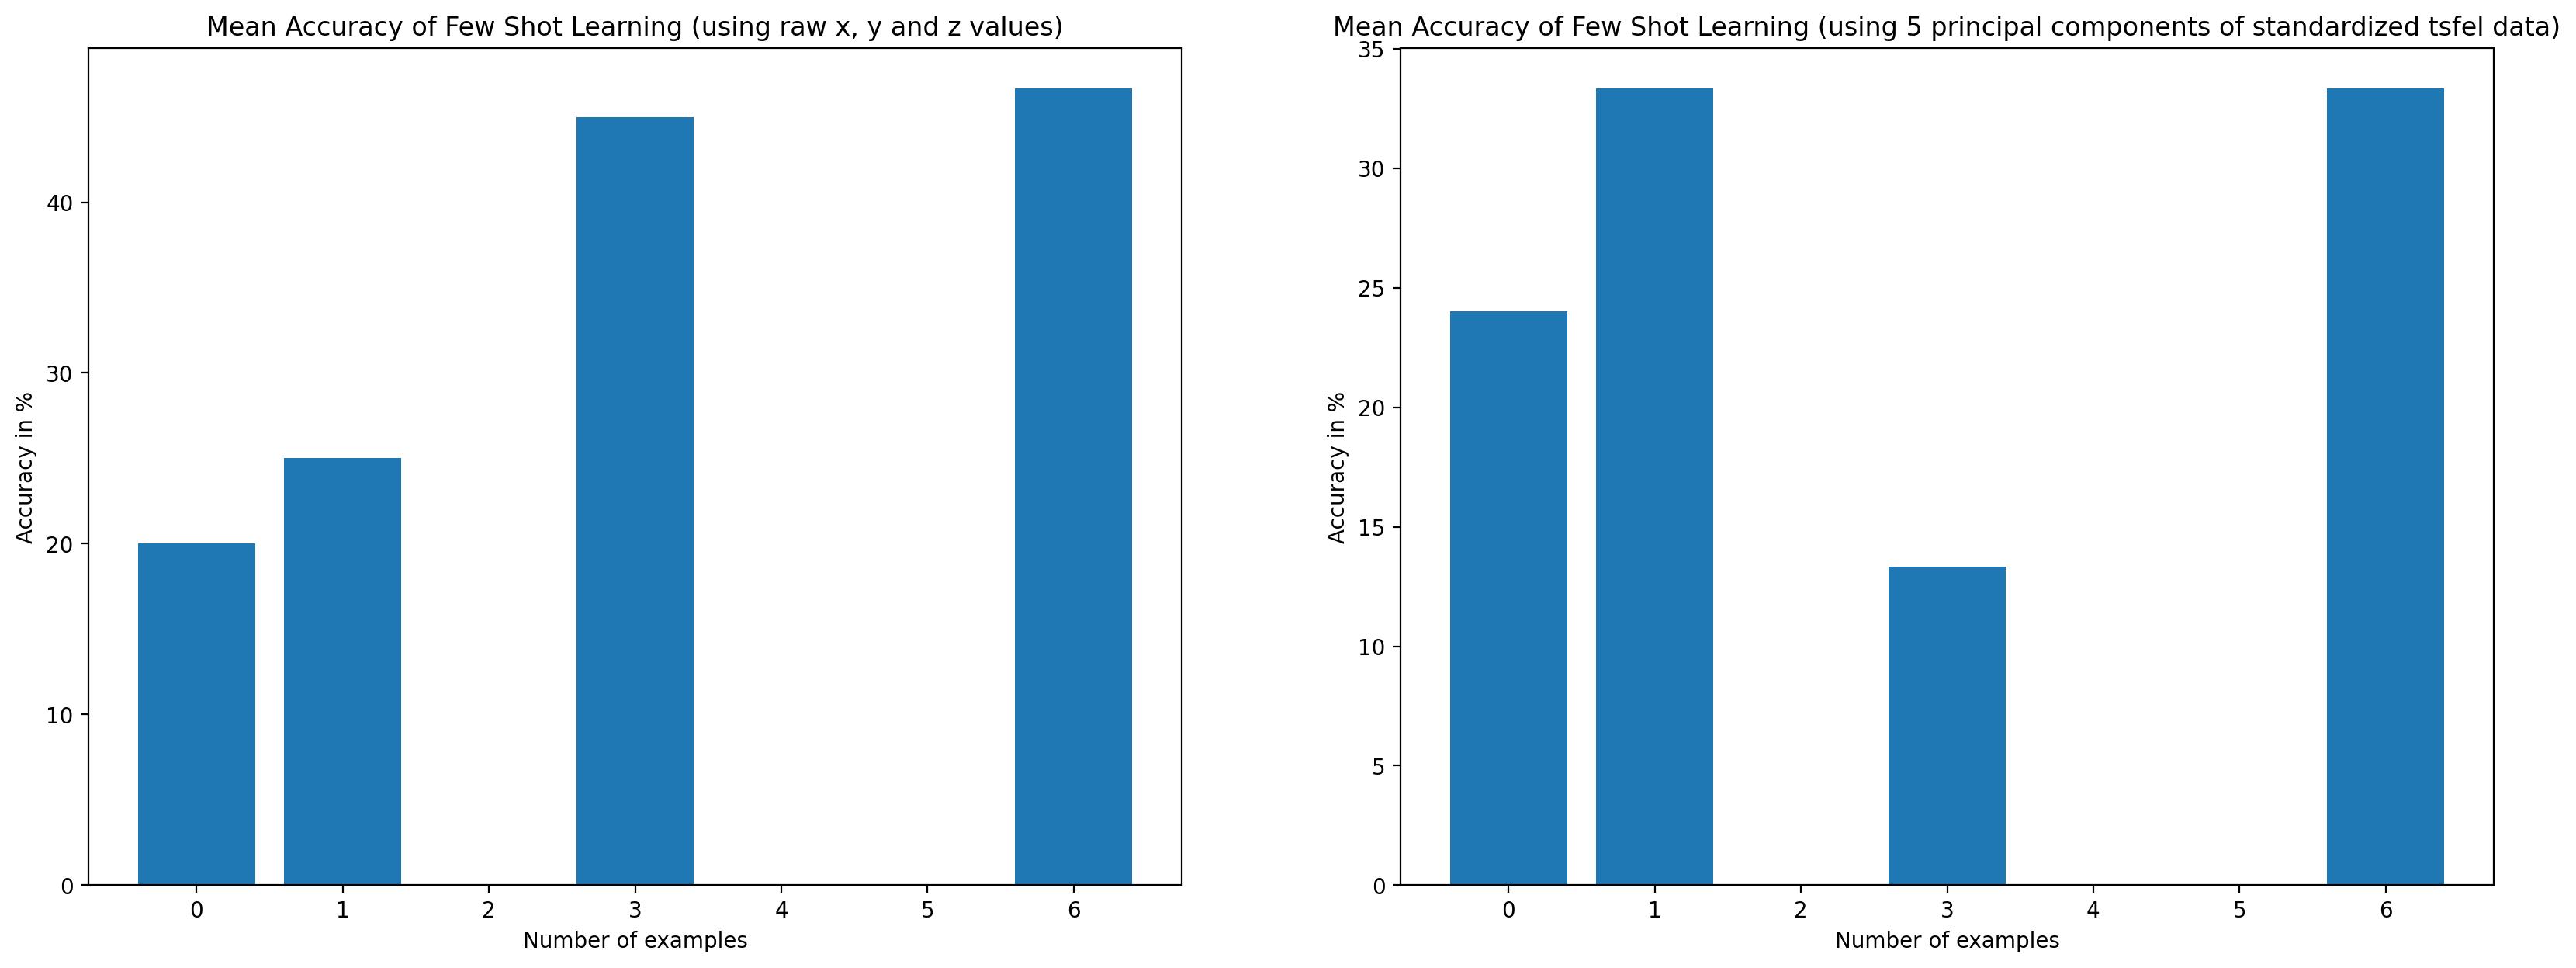

In [8]:
f = plt.figure(figsize=(20, 7))
f.add_subplot(1, 2, 1)
plt.bar([0, 1, 3, 6], [20, 25, 45, 46.67])
plt.ylabel("Accuracy in %")
plt.xlabel("Number of examples")
plt.title("Mean Accuracy of Few Shot Learning (using raw x, y and z values)")
f.add_subplot(1, 2, 2)
plt.bar([0, 1, 3, 6], [24, 33.34, 13.33, 33.33])
plt.ylabel("Accuracy in %")
plt.xlabel("Number of examples")
plt.title("Mean Accuracy of Few Shot Learning (using 5 principal components of standardized tsfel data)")
plt.show()


#### As we can see, Few Shot Learning performs better than zero shot learning.
The reasons behind this can be many, including:
- The lack of context behind the **nature, scale, variance and magnitude of the data** in zero shot learning; this problem is solved to a certain extent in few shot learning since the llm now knows what exactly is a large variance and what is a small variance by correlating with the activity.
- Since the llm now has example data for each activity in few shot learning, it can also **directly correalate the new test-data with the examples to give an answer**. Altough I doubt this is what happens inside the LLM.  

#### The reason for raw x, y and z data prompts performing better than featurized and principal components analyzed data may be:
- The LLM is **bad at understanding meaning through numbers**, therefore, even when data through PCA has more information, the LLM fails to understand it.
- The raw x, y and z data atleast gives the LLM the context that these numbers give movement information in 3 different axes.

### 2. Quantitatively compare the accuracy of Few-Shot Learning with Decision Trees (You may use a subset of the test set if you encounter rate-limiting issues). Which method performs better? Why? [1 marks]

> The best accuracy obtained during **Few-Shot learning** is by passing the raw x, y and z data to LLM with appropriate context through the prompt.  
> Accuracy = `46.67%` (6-shot) (mean over 60 trials)

> The best accuracy obtained by **Decision Trees** using raw x, y and z data is:  
> Accuracy = `64.81%` (depth = 6)

#### Using the best 5 principal components of standardized tsfel data

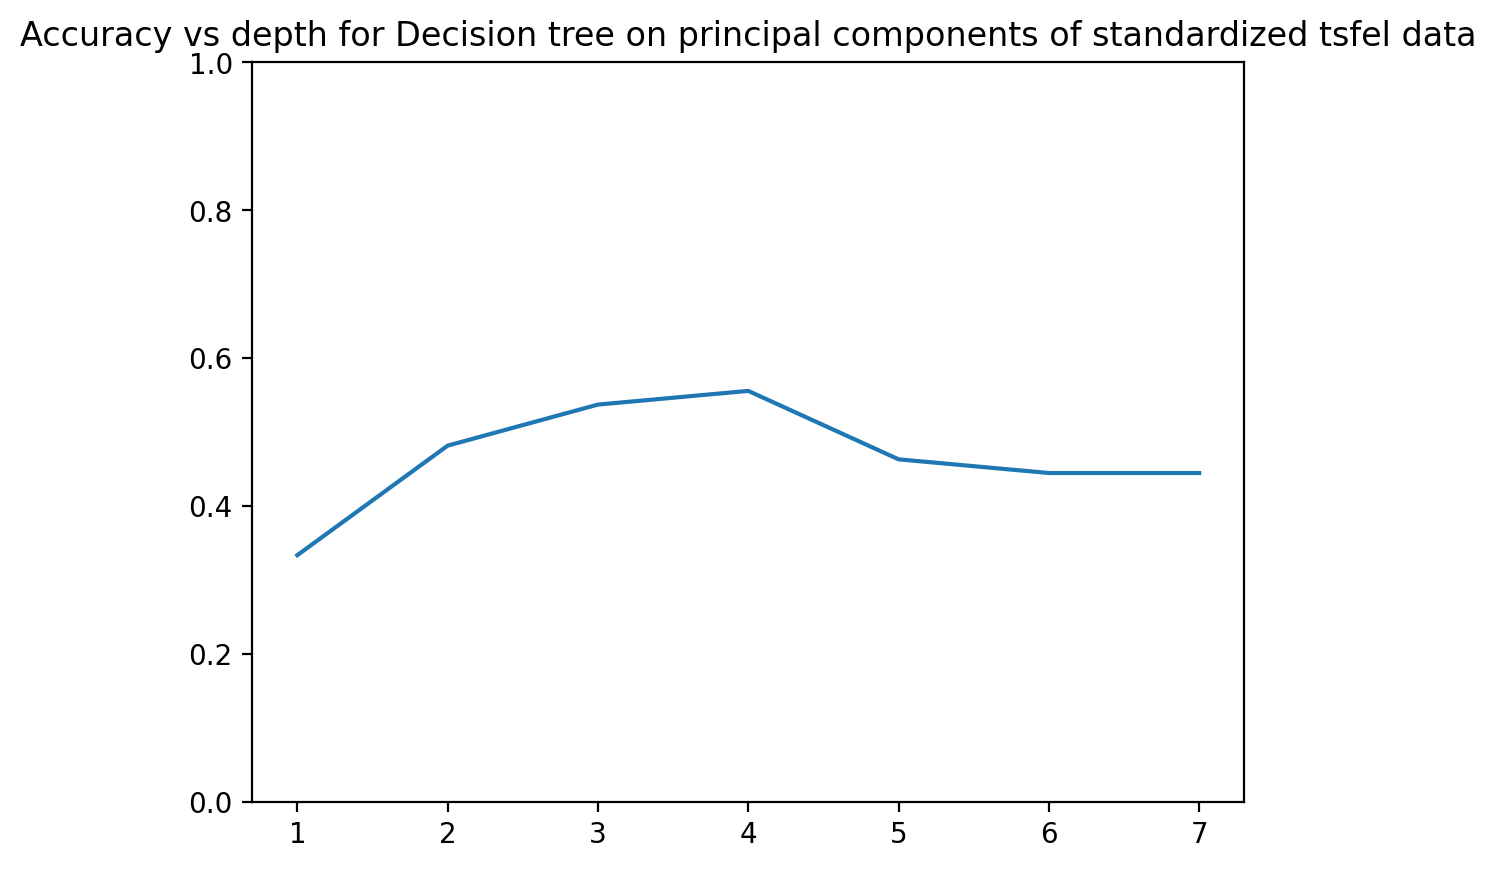

Max accuracy: 55.56 %


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

m = []
for i in range(1, 8):
    clf = DecisionTreeClassifier(random_state=42,max_depth=i)
    clf.fit(pca_features_train, y_train)
    y_pred = clf.predict(pca_features_test)
    m.append((accuracy_score(y_test, y_pred)))

plt.plot(list(range(1, 8)), m)
plt.ylim(0,1)
plt.title("Accuracy vs depth for Decision tree on principal components of standardized tsfel data")
plt.show()
print("Max accuracy:",np.round(np.max(m)*100, 2),"%")

> The best accuracy obtained during **Few-Shot learning**  by passing the top 5 principal components of standardized tsfel data is:  
> Accuracy = `33.33%` (6-shot) (mean over 30 trials)  

> The best accuracy obtained by **Decision Trees** using top 5 principal components of standardized tsfel data is:  
> Accuracy = `55.56%` (depth = 4)

### 3. What are the limitations of Zero-Shot Learning and Few-Shot Learning in the context of classifying human activities based on featurized accelerometer data? [1 marks]

Since there is a lack of context behind the **nature, scale, variance and magnitude of the data** in zero shot learning, LLMS - which have a huge knowledge base can get 'lost'. Also, _LLMs are known to perform poorly in arithmetic and numerical tasks_, which are beneficial skills in our current experiment of determining human activity.  
In `Zero-shot learning`, the lack of context and point of reference, the LLM has very little idea about the specific data values. Hence, this technique is **limited by how common of a task it is used for**, such that the LLM has more information/knowledge about it from the language corpora used for its training.  

By supplementing the prompt with context, as in `Few-Shot learning`, we essentially anchor the input data within a specific domain. Anchoring helps the model to navigate its vast knowledge base and tap into the relevant information more effectively.  
Even `Few-Shot learning` cannot vastly improve upon the performance of the LLM model in classifying human activity since **not a lot of cases/variations in the different activities and data can be given to the LLM** at once. Also, the **problem with arithmetic and numbers analysis stays**. While the _performance increases by increasing the number of examples provided, it stagnates_ after a point where it is bottlenecked by the understanding capabilities of the LLM itself.  
To further increase the accuracy by any substantial amount, we would need to pass in a lot more example data points. This will get limited by the **rate/token limits of the LLM API service (`groq` in this case) and also by the context windows of the LLM** itself.

> Context window is basically the maximum amount of text (measured in tokens) that the model can consider or "remember" at any given time during a conversation or while processing input. The context window size is crucial because it determines how much information the model can keep in mind when generating responses.

The Context windows of some of the models are:
| LLM | Context Window Size |
| --- | --- |
| LLaMA-3-Groq-Tool-Use | 128k |
| LLaMA-3.1 70B | 131k |
| LLaMA-3.1 8B | 131k |
| LLaMA-3 70B | 8.2k |
| LLaMA-3 8B | 8.2k |
| Mistral 7B | 128k |
| Mistral 8x7B | 128k |
| Mistral 8x22B | 128k |
| NeMo | 128k |


### 4. What does the model classify when given input from an entirely new activity that it hasn't seen before? [0.5 mark]


### 5. Test the model with random data (ensuring the data has the same dimensions and range as the previous input) and report the results. [0.5 mark]


### _References_
- [Human Activity Recognition using Time Series Feature
Extraction and Active Learning
](https://dl.acm.org/doi/pdf/10.1145/3549737.3549787)